In [1]:
import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# Reading Data

In [2]:
image_path = []
labels = []

for label in os.listdir("dataset/"):
    for image in os.listdir(f"dataset/{label}"):
        image_path.append(f"dataset/{label}/{image}")
        labels.append(label)

data_df = pd.DataFrame({"image_path": image_path, "label": labels})
data_df.head()


,image_path,label
0,dataset/cataract/0_left.jpg,cataract
1,dataset/cataract/103_left.jpg,cataract
2,dataset/cataract/1062_right.jpg,cataract
3,dataset/cataract/1083_left.jpg,cataract
4,dataset/cataract/1084_right.jpg,cataract


# Data Splitting

In [3]:
train = data_df.sample(frac=0.8, random_state=42).reset_index(drop=True)
test = data_df.drop(train.index).reset_index(drop=True)
val = test.sample(frac=0.5, random_state=42).reset_index(drop=True)
test = test.drop(val.index).reset_index(drop=True)

print(train.shape, val.shape, test.shape)

(3704, 2) (463, 2) (463, 2)


In [4]:
label_encoder = LabelEncoder()  
label_encoder.fit(train["label"])

transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
transformed_labels= label_encoder.transform(train["label"])
print(label_encoder.inverse_transform([0]))
print(label_encoder.inverse_transform([1]))
print(label_encoder.inverse_transform([2]))
print(label_encoder.inverse_transform([3]))


['cataract']
['diabetic_retinopathy']
['glaucoma']
['normal']


In [6]:
label_encoder.classes_

array(['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'],
      dtype=object)

In [7]:
import pickle
idx_to_name = {idx: name for idx, name in enumerate(label_encoder.classes_)}

with open("idx_to_name.pkl", "wb") as f:
    pickle.dump(idx_to_name, f)

# Custom Dataset Class

In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['label'])).to(device)
        

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)
        else :
            image = image.to(device)
        return image, label

    

# Create datasets

In [9]:
train_dataset = CustomDataset(train, transform=transforms)
val_dataset = CustomDataset(val, transform=transforms)
test_dataset = CustomDataset(test, transform=transforms)

# Visualizing the Images

In [10]:
data_df.sample(n=1, random_state=42)

,image_path,label
805,dataset/cataract/_328_3269333.jpg,cataract


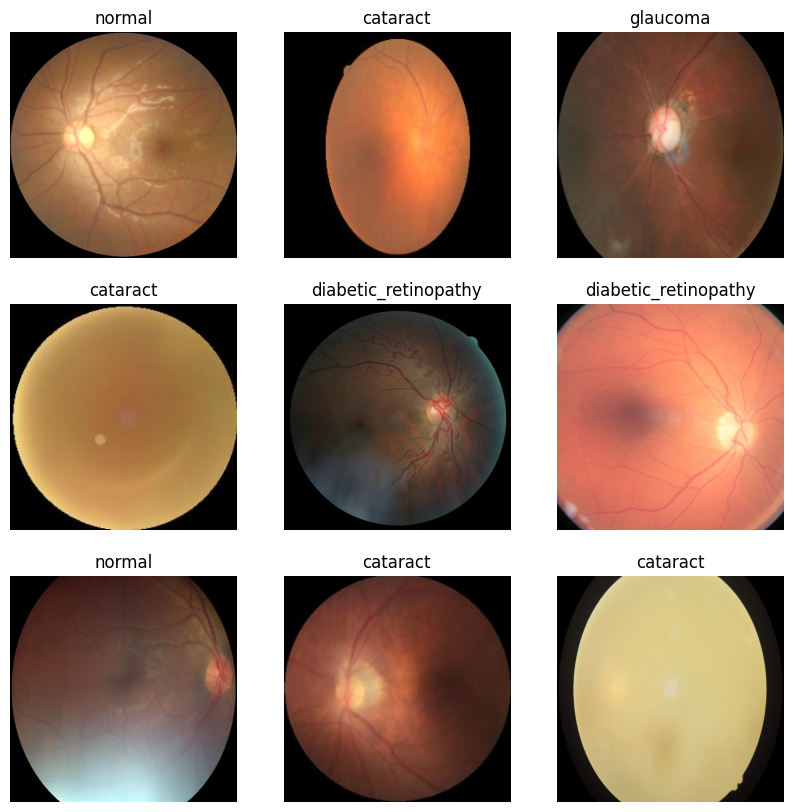

In [11]:
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
for row in range(n_rows):
    for col in range(n_cols):
        sample = data_df.sample(n=1)
        image= Image.open(sample["image_path"].iloc[0]).convert("RGB")
        label = sample["label"].iloc[0]
        axes[row, col].set_title(label)
        axes[row, col].imshow(image)
        axes[row, col].axis('off')


plt.show()


# HyperParameters

In [17]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 5


# DataLoaders

In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

In [19]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        # Load pre-trained EfficientNet-B0
        self.base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Replace the classifier with a custom one
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.base_model(x)

# Example usage
num_classes = data_df["label"].nunique()
model = EfficientNetModel(num_classes).to(device)
print(model)

EfficientNetModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

# Model Summary

In [20]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

# Loss and Optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)


# Training

In [22]:
total_loss_train_plot= []
total_loss_val_plot = []
total_accuracy_train_plot = []
total_accuracy_val_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        model.train()
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item() 
        train_loss.backward()
        train_acc = (torch.argmax(outputs, 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            model.eval()
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item() 
            val_acc = (torch.argmax(outputs, 1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train /= len(train_loader.dataset)
    total_loss_val /= len(val_loader.dataset)
    total_acc_train /= len(train_loader.dataset)
    total_acc_val /= len(val_loader.dataset)
    total_loss_train_plot.append(total_loss_train)
    total_loss_val_plot.append(total_loss_val)
    total_accuracy_train_plot.append(total_acc_train)
    total_accuracy_val_plot.append(total_acc_val)
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {total_loss_train:.4f}, Train Accuracy: {total_acc_train:.4f} - "
          f"Val Loss: {total_loss_val:.4f}, Val Accuracy: {total_acc_val:.4f}")
    
    print("="*50)



Epoch 1/5 - Train Loss: 0.0210, Train Accuracy: 0.7665 - Val Loss: 0.0096, Val Accuracy: 0.9244
Epoch 2/5 - Train Loss: 0.0078, Train Accuracy: 0.9106 - Val Loss: 0.0084, Val Accuracy: 0.9114
Epoch 3/5 - Train Loss: 0.0054, Train Accuracy: 0.9395 - Val Loss: 0.0038, Val Accuracy: 0.9611
Epoch 4/5 - Train Loss: 0.0036, Train Accuracy: 0.9627 - Val Loss: 0.0026, Val Accuracy: 0.9784
Epoch 5/5 - Train Loss: 0.0022, Train Accuracy: 0.9789 - Val Loss: 0.0043, Val Accuracy: 0.9633


# Testing

In [23]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in test_loader:
        model.eval()
        outputs = model(inputs)
        test_loss = criterion(outputs, labels)
        total_loss_test += test_loss.item() 
        test_acc = (torch.argmax(outputs, 1) == labels).sum().item()
        total_acc_test += test_acc

    total_loss_test /= len(test_loader.dataset)
    total_acc_test /= len(test_loader.dataset)
    print(f"Test Loss: {total_loss_test:.4f}, Test Accuracy: {total_acc_test:.4f}")

Test Loss: 0.0048, Test Accuracy: 0.9611


# Plotting Training Progress

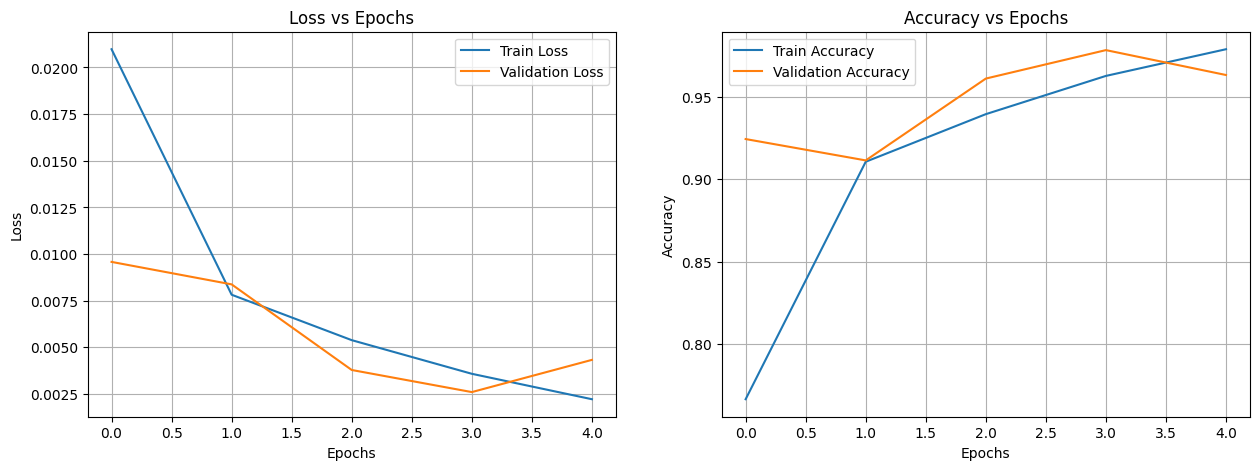

In [24]:
fig, axs = plt.subplots(1,2 , figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_val_plot, label="Validation Loss")
axs[0].set_title("Loss vs Epochs")
axs[0].set_xlabel("Epochs") 
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].plot(total_accuracy_train_plot, label="Train Accuracy")
axs[1].plot(total_accuracy_val_plot, label="Validation Accuracy")
axs[1].set_title("Accuracy vs Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [25]:
# save the model 
torch.save(model.state_dict(), "efficientnet_model.pth")
# load the model
# model = EfficientNetModel(num_classes).to(device)
# model.load_state_dict(torch.load("efficientnet_model.pth"))
# model.eval()

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        # Load pre-trained EfficientNet-B0
        self.base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Replace the classifier with a custom one
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.base_model(x)

# Example usage
num_classes = 4
model = EfficientNetModel(num_classes).to(device)
model.load_state_dict(torch.load("efficientnet_model.pth"))

def predict_image(image):
    image = transforms(image).unsqueeze(0).to(device)

    output = model(image)
    output = torch.argmax(output, axis=1)[1].item()

